# GANomaly
- 2020.08.17 : gen 10 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 10)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3801 / DC_loss : 0.6488
- D(x):0.4943 / D(DC(z1)) : 0.4910 / D(DC(z2)) : 0.5227
[1/100][1/15]
- D_loss : 1.3774 / DC_loss : 0.6485
- D(x):0.4932 / D(DC(z1)) : 0.4884 / D(DC(z2)) : 0.5228
[1/100][2/15]
- D_loss : 1.3674 / DC_loss : 0.6524
- D(x):0.4949 / D(DC(z1)) : 0.4851 / D(DC(z2)) : 0.5208
[1/100][3/15]
- D_loss : 1.3597 / DC_loss : 0.6598
- D(x):0.4942 / D(DC(z1)) : 0.4803 / D(DC(z2)) : 0.5170
[1/100][4/15]
- D_loss : 1.3542 / DC_loss : 0.6645
- D(x):0.4942 / D(DC(z1)) : 0.4774 / D(DC(z2)) : 0.5146
[1/100][5/15]
- D_loss : 1.3491 / DC_loss : 0.6699
- D(x):0.4944 / D(DC(z1)) : 0.4749 / D(DC(z2)) : 0.5118
[1/100][6/15]
- D_loss : 1.3385 / DC_loss : 0.6759
- D(x):0.4964 / D(DC(z1)) : 0.4714 / D(DC(z2)) : 0.5087
[1/100][7/15]
- D_loss : 1.3304 / DC_loss : 0.6854
- D(x):0.4952 / D(DC(z1)) : 0.4658 / D(DC(z2)) : 0.5039
[1/100][8/15]
- D_loss : 1.3304 / DC_loss : 0.6890
- D(x):0.4933 / D(DC(z1)) : 0.4637 / D(DC(z2)) : 0.5021
[1/100][9/15]
- D_loss : 1.3247 / DC_

[6/100][2/15]
- D_loss : 1.4612 / DC_loss : 0.6324
- D(x):0.4909 / D(DC(z1)) : 0.5272 / D(DC(z2)) : 0.5313
[6/100][3/15]
- D_loss : 1.4598 / DC_loss : 0.6326
- D(x):0.4932 / D(DC(z1)) : 0.5287 / D(DC(z2)) : 0.5313
[6/100][4/15]
- D_loss : 1.4603 / DC_loss : 0.6381
- D(x):0.4913 / D(DC(z1)) : 0.5272 / D(DC(z2)) : 0.5283
[6/100][5/15]
- D_loss : 1.4577 / DC_loss : 0.6414
- D(x):0.4917 / D(DC(z1)) : 0.5262 / D(DC(z2)) : 0.5266
[6/100][6/15]
- D_loss : 1.4597 / DC_loss : 0.6475
- D(x):0.4882 / D(DC(z1)) : 0.5238 / D(DC(z2)) : 0.5234
[6/100][7/15]
- D_loss : 1.4512 / DC_loss : 0.6534
- D(x):0.4893 / D(DC(z1)) : 0.5208 / D(DC(z2)) : 0.5203
[6/100][8/15]
- D_loss : 1.4411 / DC_loss : 0.6584
- D(x):0.4909 / D(DC(z1)) : 0.5174 / D(DC(z2)) : 0.5177
[6/100][9/15]
- D_loss : 1.4419 / DC_loss : 0.6569
- D(x):0.4898 / D(DC(z1)) : 0.5167 / D(DC(z2)) : 0.5185
[6/100][10/15]
- D_loss : 1.4395 / DC_loss : 0.6536
- D(x):0.4915 / D(DC(z1)) : 0.5173 / D(DC(z2)) : 0.5202
[6/100][11/15]
- D_loss : 1.4548 / D

[11/100][4/15]
- D_loss : 1.3503 / DC_loss : 0.7726
- D(x):0.4820 / D(DC(z1)) : 0.4613 / D(DC(z2)) : 0.4618
[11/100][5/15]
- D_loss : 1.3568 / DC_loss : 0.7683
- D(x):0.4800 / D(DC(z1)) : 0.4628 / D(DC(z2)) : 0.4638
[11/100][6/15]
- D_loss : 1.3596 / DC_loss : 0.7651
- D(x):0.4808 / D(DC(z1)) : 0.4650 / D(DC(z2)) : 0.4653
[11/100][7/15]
- D_loss : 1.3639 / DC_loss : 0.7636
- D(x):0.4797 / D(DC(z1)) : 0.4662 / D(DC(z2)) : 0.4660
[11/100][8/15]
- D_loss : 1.3639 / DC_loss : 0.7633
- D(x):0.4803 / D(DC(z1)) : 0.4669 / D(DC(z2)) : 0.4661
[11/100][9/15]
- D_loss : 1.3604 / DC_loss : 0.7634
- D(x):0.4822 / D(DC(z1)) : 0.4671 / D(DC(z2)) : 0.4661
[11/100][10/15]
- D_loss : 1.3651 / DC_loss : 0.7610
- D(x):0.4801 / D(DC(z1)) : 0.4672 / D(DC(z2)) : 0.4672
[11/100][11/15]
- D_loss : 1.3665 / DC_loss : 0.7600
- D(x):0.4801 / D(DC(z1)) : 0.4683 / D(DC(z2)) : 0.4677
[11/100][12/15]
- D_loss : 1.3653 / DC_loss : 0.7611
- D(x):0.4814 / D(DC(z1)) : 0.4689 / D(DC(z2)) : 0.4671
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.2239 / DC_loss : 0.9080
- D(x):0.4957 / D(DC(z1)) : 0.4062 / D(DC(z2)) : 0.4033
[16/100][6/15]
- D_loss : 1.2258 / DC_loss : 0.9098
- D(x):0.4931 / D(DC(z1)) : 0.4041 / D(DC(z2)) : 0.4026
[16/100][7/15]
- D_loss : 1.2233 / DC_loss : 0.9078
- D(x):0.4938 / D(DC(z1)) : 0.4036 / D(DC(z2)) : 0.4034
[16/100][8/15]
- D_loss : 1.2106 / DC_loss : 0.9061
- D(x):0.5008 / D(DC(z1)) : 0.4045 / D(DC(z2)) : 0.4041
[16/100][9/15]
- D_loss : 1.2126 / DC_loss : 0.9070
- D(x):0.5003 / D(DC(z1)) : 0.4050 / D(DC(z2)) : 0.4037
[16/100][10/15]
- D_loss : 1.2366 / DC_loss : 0.9114
- D(x):0.4880 / D(DC(z1)) : 0.4046 / D(DC(z2)) : 0.4019
[16/100][11/15]
- D_loss : 1.2063 / DC_loss : 0.9165
- D(x):0.5015 / D(DC(z1)) : 0.4027 / D(DC(z2)) : 0.3999
[16/100][12/15]
- D_loss : 1.2132 / DC_loss : 0.9209
- D(x):0.4965 / D(DC(z1)) : 0.4007 / D(DC(z2)) : 0.3982
[16/100][13/15]
- D_loss : 1.1989 / DC_loss : 0.9211
- D(x):0.5022 / D(DC(z1)) : 0.3990 / D(DC(z2)) : 0.3981
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.1436 / DC_loss : 0.9866
- D(x):0.5115 / D(DC(z1)) : 0.3762 / D(DC(z2)) : 0.3729
[21/100][7/15]
- D_loss : 1.1244 / DC_loss : 0.9911
- D(x):0.5193 / D(DC(z1)) : 0.3739 / D(DC(z2)) : 0.3712
[21/100][8/15]
- D_loss : 1.1513 / DC_loss : 0.9884
- D(x):0.5043 / D(DC(z1)) : 0.3722 / D(DC(z2)) : 0.3722
[21/100][9/15]
- D_loss : 1.1380 / DC_loss : 0.9850
- D(x):0.5119 / D(DC(z1)) : 0.3732 / D(DC(z2)) : 0.3734
[21/100][10/15]
- D_loss : 1.1306 / DC_loss : 0.9873
- D(x):0.5166 / D(DC(z1)) : 0.3744 / D(DC(z2)) : 0.3726
[21/100][11/15]
- D_loss : 1.1281 / DC_loss : 0.9908
- D(x):0.5171 / D(DC(z1)) : 0.3735 / D(DC(z2)) : 0.3713
[21/100][12/15]
- D_loss : 1.1190 / DC_loss : 0.9938
- D(x):0.5208 / D(DC(z1)) : 0.3722 / D(DC(z2)) : 0.3702
[21/100][13/15]
- D_loss : 1.1251 / DC_loss : 0.9879
- D(x):0.5170 / D(DC(z1)) : 0.3712 / D(DC(z2)) : 0.3724
[21/100][14/15]
- D_loss : 1.1391 / DC_loss : 0.9757
- D(x):0.5118 / D(DC(z1)) : 0.3736 / D(DC(z2)) : 0.3769
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.0266 / DC_loss : 1.1071
- D(x):0.5342 / D(DC(z1)) : 0.3289 / D(DC(z2)) : 0.3305
[26/100][8/15]
- D_loss : 1.0091 / DC_loss : 1.1069
- D(x):0.5459 / D(DC(z1)) : 0.3319 / D(DC(z2)) : 0.3306
[26/100][9/15]
- D_loss : 1.0352 / DC_loss : 1.0902
- D(x):0.5320 / D(DC(z1)) : 0.3318 / D(DC(z2)) : 0.3362
[26/100][10/15]
- D_loss : 1.0280 / DC_loss : 1.0749
- D(x):0.5404 / D(DC(z1)) : 0.3375 / D(DC(z2)) : 0.3413
[26/100][11/15]
- D_loss : 1.0182 / DC_loss : 1.0729
- D(x):0.5501 / D(DC(z1)) : 0.3429 / D(DC(z2)) : 0.3420
[26/100][12/15]
- D_loss : 1.0362 / DC_loss : 1.0736
- D(x):0.5406 / D(DC(z1)) : 0.3434 / D(DC(z2)) : 0.3418
[26/100][13/15]
- D_loss : 1.0114 / DC_loss : 1.0799
- D(x):0.5540 / D(DC(z1)) : 0.3430 / D(DC(z2)) : 0.3396
[26/100][14/15]
- D_loss : 1.0381 / DC_loss : 1.0709
- D(x):0.5380 / D(DC(z1)) : 0.3409 / D(DC(z2)) : 0.3427
[27/100][0/15]
- D_loss : 1.0009 / DC_loss : 1.0677
- D(x):0.5606 / D(DC(z1)) : 0.3439 / D(DC(z2)) : 0.3438
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.2066 / DC_loss : 0.8306
- D(x):0.5371 / D(DC(z1)) : 0.4425 / D(DC(z2)) : 0.4358
[31/100][9/15]
- D_loss : 1.1433 / DC_loss : 0.8579
- D(x):0.5671 / D(DC(z1)) : 0.4374 / D(DC(z2)) : 0.4241
[31/100][10/15]
- D_loss : 1.1319 / DC_loss : 0.8769
- D(x):0.5621 / D(DC(z1)) : 0.4261 / D(DC(z2)) : 0.4161
[31/100][11/15]
- D_loss : 1.1520 / DC_loss : 0.8782
- D(x):0.5438 / D(DC(z1)) : 0.4182 / D(DC(z2)) : 0.4155
[31/100][12/15]
- D_loss : 1.1327 / DC_loss : 0.8735
- D(x):0.5538 / D(DC(z1)) : 0.4177 / D(DC(z2)) : 0.4175
[31/100][13/15]
- D_loss : 1.1313 / DC_loss : 0.8785
- D(x):0.5560 / D(DC(z1)) : 0.4193 / D(DC(z2)) : 0.4154
[31/100][14/15]
- D_loss : 1.0997 / DC_loss : 0.8824
- D(x):0.5718 / D(DC(z1)) : 0.4173 / D(DC(z2)) : 0.4138
[32/100][0/15]
- D_loss : 1.1066 / DC_loss : 0.8937
- D(x):0.5660 / D(DC(z1)) : 0.4154 / D(DC(z2)) : 0.4092
[32/100][1/15]
- D_loss : 1.0797 / DC_loss : 0.9092
- D(x):0.5765 / D(DC(z1)) : 0.4104 / D(DC(z2)) : 0.4028
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.4092 / DC_loss : 0.6203
- D(x):0.5123 / D(DC(z1)) : 0.5219 / D(DC(z2)) : 0.5383
[36/100][10/15]
- D_loss : 1.3632 / DC_loss : 0.6231
- D(x):0.5419 / D(DC(z1)) : 0.5270 / D(DC(z2)) : 0.5369
[36/100][11/15]
- D_loss : 1.4089 / DC_loss : 0.6277
- D(x):0.5050 / D(DC(z1)) : 0.5150 / D(DC(z2)) : 0.5343
[36/100][12/15]
- D_loss : 1.3991 / DC_loss : 0.6247
- D(x):0.5215 / D(DC(z1)) : 0.5259 / D(DC(z2)) : 0.5359
[36/100][13/15]
- D_loss : 1.3720 / DC_loss : 0.6423
- D(x):0.5331 / D(DC(z1)) : 0.5234 / D(DC(z2)) : 0.5269
[36/100][14/15]
- D_loss : 1.3913 / DC_loss : 0.6600
- D(x):0.5124 / D(DC(z1)) : 0.5129 / D(DC(z2)) : 0.5176
[37/100][0/15]
- D_loss : 1.3949 / DC_loss : 0.6559
- D(x):0.5072 / D(DC(z1)) : 0.5099 / D(DC(z2)) : 0.5199
[37/100][1/15]
- D_loss : 1.3717 / DC_loss : 0.6585
- D(x):0.5207 / D(DC(z1)) : 0.5112 / D(DC(z2)) : 0.5186
[37/100][2/15]
- D_loss : 1.4019 / DC_loss : 0.6844
- D(x):0.4804 / D(DC(z1)) : 0.4859 / D(DC(z2)) : 0.5054
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.4517 / DC_loss : 0.7059
- D(x):0.4569 / D(DC(z1)) : 0.4872 / D(DC(z2)) : 0.4938
[41/100][11/15]
- D_loss : 1.3754 / DC_loss : 0.7425
- D(x):0.4797 / D(DC(z1)) : 0.4729 / D(DC(z2)) : 0.4761
[41/100][12/15]
- D_loss : 1.3733 / DC_loss : 0.7368
- D(x):0.4837 / D(DC(z1)) : 0.4761 / D(DC(z2)) : 0.4788
[41/100][13/15]
- D_loss : 1.3935 / DC_loss : 0.7325
- D(x):0.4740 / D(DC(z1)) : 0.4760 / D(DC(z2)) : 0.4808
[41/100][14/15]
- D_loss : 1.3873 / DC_loss : 0.7265
- D(x):0.4795 / D(DC(z1)) : 0.4790 / D(DC(z2)) : 0.4836
[42/100][0/15]
- D_loss : 1.4016 / DC_loss : 0.7462
- D(x):0.4589 / D(DC(z1)) : 0.4632 / D(DC(z2)) : 0.4743
[42/100][1/15]
- D_loss : 1.3796 / DC_loss : 0.7312
- D(x):0.4750 / D(DC(z1)) : 0.4700 / D(DC(z2)) : 0.4814
[42/100][2/15]
- D_loss : 1.4010 / DC_loss : 0.6981
- D(x):0.4803 / D(DC(z1)) : 0.4869 / D(DC(z2)) : 0.4976
[42/100][3/15]
- D_loss : 1.3918 / DC_loss : 0.7112
- D(x):0.4750 / D(DC(z1)) : 0.4764 / D(DC(z2)) : 0.4911
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 1.4036 / DC_loss : 0.6767
- D(x):0.4937 / D(DC(z1)) : 0.5022 / D(DC(z2)) : 0.5083
[46/100][12/15]
- D_loss : 1.3838 / DC_loss : 0.6866
- D(x):0.4966 / D(DC(z1)) : 0.4952 / D(DC(z2)) : 0.5033
[46/100][13/15]
- D_loss : 1.3562 / DC_loss : 0.6946
- D(x):0.5042 / D(DC(z1)) : 0.4889 / D(DC(z2)) : 0.4993
[46/100][14/15]
- D_loss : 1.3752 / DC_loss : 0.6759
- D(x):0.5080 / D(DC(z1)) : 0.5022 / D(DC(z2)) : 0.5088
[47/100][0/15]
- D_loss : 1.3811 / DC_loss : 0.6879
- D(x):0.4998 / D(DC(z1)) : 0.4971 / D(DC(z2)) : 0.5027
[47/100][1/15]
- D_loss : 1.3830 / DC_loss : 0.6904
- D(x):0.4996 / D(DC(z1)) : 0.4978 / D(DC(z2)) : 0.5014
[47/100][2/15]
- D_loss : 1.4161 / DC_loss : 0.6835
- D(x):0.4860 / D(DC(z1)) : 0.5005 / D(DC(z2)) : 0.5049
[47/100][3/15]
- D_loss : 1.3987 / DC_loss : 0.6942
- D(x):0.4876 / D(DC(z1)) : 0.4935 / D(DC(z2)) : 0.4995
[47/100][4/15]
- D_loss : 1.4040 / DC_loss : 0.6874
- D(x):0.4903 / D(DC(z1)) : 0.4990 / D(DC(z2)) : 0.5029
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.3774 / DC_loss : 0.7218
- D(x):0.4905 / D(DC(z1)) : 0.4856 / D(DC(z2)) : 0.4859
[51/100][13/15]
- D_loss : 1.3580 / DC_loss : 0.7139
- D(x):0.4913 / D(DC(z1)) : 0.4764 / D(DC(z2)) : 0.4898
[51/100][14/15]
- D_loss : 1.4015 / DC_loss : 0.7010
- D(x):0.4826 / D(DC(z1)) : 0.4896 / D(DC(z2)) : 0.4962
[52/100][0/15]
- D_loss : 1.4030 / DC_loss : 0.6831
- D(x):0.4913 / D(DC(z1)) : 0.4993 / D(DC(z2)) : 0.5051
[52/100][1/15]
- D_loss : 1.3700 / DC_loss : 0.7183
- D(x):0.4900 / D(DC(z1)) : 0.4812 / D(DC(z2)) : 0.4877
[52/100][2/15]
- D_loss : 1.3807 / DC_loss : 0.6945
- D(x):0.4995 / D(DC(z1)) : 0.4965 / D(DC(z2)) : 0.4994
[52/100][3/15]
- D_loss : 1.3860 / DC_loss : 0.6819
- D(x):0.4981 / D(DC(z1)) : 0.4978 / D(DC(z2)) : 0.5057
[52/100][4/15]
- D_loss : 1.3713 / DC_loss : 0.6965
- D(x):0.4992 / D(DC(z1)) : 0.4915 / D(DC(z2)) : 0.4983
[52/100][5/15]
- D_loss : 1.3978 / DC_loss : 0.6958
- D(x):0.4884 / D(DC(z1)) : 0.4939 / D(DC(z2)) : 0.4987
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3992 / DC_loss : 0.6791
- D(x):0.4959 / D(DC(z1)) : 0.5022 / D(DC(z2)) : 0.5071
[56/100][14/15]
- D_loss : 1.4052 / DC_loss : 0.6882
- D(x):0.4868 / D(DC(z1)) : 0.4959 / D(DC(z2)) : 0.5025
[57/100][0/15]
- D_loss : 1.4193 / DC_loss : 0.6896
- D(x):0.4815 / D(DC(z1)) : 0.4975 / D(DC(z2)) : 0.5018
[57/100][1/15]
- D_loss : 1.3960 / DC_loss : 0.6919
- D(x):0.4917 / D(DC(z1)) : 0.4963 / D(DC(z2)) : 0.5006
[57/100][2/15]
- D_loss : 1.3960 / DC_loss : 0.6849
- D(x):0.4968 / D(DC(z1)) : 0.5015 / D(DC(z2)) : 0.5042
[57/100][3/15]
- D_loss : 1.3766 / DC_loss : 0.7009
- D(x):0.4953 / D(DC(z1)) : 0.4902 / D(DC(z2)) : 0.4962
[57/100][4/15]
- D_loss : 1.4180 / DC_loss : 0.7019
- D(x):0.4759 / D(DC(z1)) : 0.4909 / D(DC(z2)) : 0.4957
[57/100][5/15]
- D_loss : 1.3931 / DC_loss : 0.7039
- D(x):0.4850 / D(DC(z1)) : 0.4880 / D(DC(z2)) : 0.4947
[57/100][6/15]
- D_loss : 1.3691 / DC_loss : 0.7000
- D(x):0.5005 / D(DC(z1)) : 0.4917 / D(DC(z2)) : 0.4966
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 1.3906 / DC_loss : 0.7008
- D(x):0.4903 / D(DC(z1)) : 0.4921 / D(DC(z2)) : 0.4962
[62/100][0/15]
- D_loss : 1.3819 / DC_loss : 0.6974
- D(x):0.4916 / D(DC(z1)) : 0.4891 / D(DC(z2)) : 0.4979
[62/100][1/15]
- D_loss : 1.3720 / DC_loss : 0.6865
- D(x):0.5036 / D(DC(z1)) : 0.4963 / D(DC(z2)) : 0.5034
[62/100][2/15]
- D_loss : 1.3945 / DC_loss : 0.6937
- D(x):0.4918 / D(DC(z1)) : 0.4957 / D(DC(z2)) : 0.4998
[62/100][3/15]
- D_loss : 1.3690 / DC_loss : 0.6939
- D(x):0.5031 / D(DC(z1)) : 0.4943 / D(DC(z2)) : 0.4997
[62/100][4/15]
- D_loss : 1.3785 / DC_loss : 0.6940
- D(x):0.4978 / D(DC(z1)) : 0.4937 / D(DC(z2)) : 0.4996
[62/100][5/15]
- D_loss : 1.3783 / DC_loss : 0.6894
- D(x):0.5001 / D(DC(z1)) : 0.4960 / D(DC(z2)) : 0.5020
[62/100][6/15]
- D_loss : 1.3597 / DC_loss : 0.6911
- D(x):0.5105 / D(DC(z1)) : 0.4970 / D(DC(z2)) : 0.5011
[62/100][7/15]
- D_loss : 1.3716 / DC_loss : 0.6806
- D(x):0.5088 / D(DC(z1)) : 0.5011 / D(DC(z2)) : 0.5064
[62/100][8/15]
- D_loss : 1

[67/100][0/15]
- D_loss : 1.3728 / DC_loss : 0.6907
- D(x):0.4990 / D(DC(z1)) : 0.4920 / D(DC(z2)) : 0.5013
[67/100][1/15]
- D_loss : 1.3470 / DC_loss : 0.6964
- D(x):0.5097 / D(DC(z1)) : 0.4897 / D(DC(z2)) : 0.4985
[67/100][2/15]
- D_loss : 1.3758 / DC_loss : 0.6944
- D(x):0.5004 / D(DC(z1)) : 0.4950 / D(DC(z2)) : 0.4995
[67/100][3/15]
- D_loss : 1.3654 / DC_loss : 0.7080
- D(x):0.4963 / D(DC(z1)) : 0.4855 / D(DC(z2)) : 0.4927
[67/100][4/15]
- D_loss : 1.3554 / DC_loss : 0.6941
- D(x):0.5057 / D(DC(z1)) : 0.4900 / D(DC(z2)) : 0.4997
[67/100][5/15]
- D_loss : 1.3690 / DC_loss : 0.6982
- D(x):0.4965 / D(DC(z1)) : 0.4875 / D(DC(z2)) : 0.4976
[67/100][6/15]
- D_loss : 1.3815 / DC_loss : 0.6883
- D(x):0.4984 / D(DC(z1)) : 0.4958 / D(DC(z2)) : 0.5025
[67/100][7/15]
- D_loss : 1.3934 / DC_loss : 0.6880
- D(x):0.4950 / D(DC(z1)) : 0.4983 / D(DC(z2)) : 0.5027
[67/100][8/15]
- D_loss : 1.3750 / DC_loss : 0.6915
- D(x):0.5008 / D(DC(z1)) : 0.4950 / D(DC(z2)) : 0.5009
[67/100][9/15]
- D_loss : 1.

[72/100][1/15]
- D_loss : 1.3638 / DC_loss : 0.7002
- D(x):0.5033 / D(DC(z1)) : 0.4919 / D(DC(z2)) : 0.4965
[72/100][2/15]
- D_loss : 1.3440 / DC_loss : 0.7085
- D(x):0.5086 / D(DC(z1)) : 0.4871 / D(DC(z2)) : 0.4925
[72/100][3/15]
- D_loss : 1.3678 / DC_loss : 0.6910
- D(x):0.5078 / D(DC(z1)) : 0.4984 / D(DC(z2)) : 0.5012
[72/100][4/15]
- D_loss : 1.3368 / DC_loss : 0.7206
- D(x):0.4996 / D(DC(z1)) : 0.4740 / D(DC(z2)) : 0.4865
[72/100][5/15]
- D_loss : 1.3625 / DC_loss : 0.7010
- D(x):0.5015 / D(DC(z1)) : 0.4893 / D(DC(z2)) : 0.4962
[72/100][6/15]
- D_loss : 1.3336 / DC_loss : 0.7101
- D(x):0.5106 / D(DC(z1)) : 0.4839 / D(DC(z2)) : 0.4917
[72/100][7/15]
- D_loss : 1.3731 / DC_loss : 0.6927
- D(x):0.5010 / D(DC(z1)) : 0.4941 / D(DC(z2)) : 0.5003
[72/100][8/15]
- D_loss : 1.3676 / DC_loss : 0.7058
- D(x):0.4973 / D(DC(z1)) : 0.4876 / D(DC(z2)) : 0.4938
[72/100][9/15]
- D_loss : 1.3733 / DC_loss : 0.7171
- D(x):0.4869 / D(DC(z1)) : 0.4796 / D(DC(z2)) : 0.4882
[72/100][10/15]
- D_loss : 1

[77/100][2/15]
- D_loss : 1.3407 / DC_loss : 0.7075
- D(x):0.5059 / D(DC(z1)) : 0.4827 / D(DC(z2)) : 0.4929
[77/100][3/15]
- D_loss : 1.3496 / DC_loss : 0.7031
- D(x):0.5022 / D(DC(z1)) : 0.4835 / D(DC(z2)) : 0.4951
[77/100][4/15]
- D_loss : 1.3235 / DC_loss : 0.6845
- D(x):0.5157 / D(DC(z1)) : 0.4837 / D(DC(z2)) : 0.5045
[77/100][5/15]
- D_loss : 1.3381 / DC_loss : 0.6999
- D(x):0.5093 / D(DC(z1)) : 0.4847 / D(DC(z2)) : 0.4967
[77/100][6/15]
- D_loss : 1.3305 / DC_loss : 0.7074
- D(x):0.5103 / D(DC(z1)) : 0.4819 / D(DC(z2)) : 0.4930
[77/100][7/15]
- D_loss : 1.3478 / DC_loss : 0.6919
- D(x):0.5131 / D(DC(z1)) : 0.4934 / D(DC(z2)) : 0.5010
[77/100][8/15]
- D_loss : 1.3506 / DC_loss : 0.7080
- D(x):0.5073 / D(DC(z1)) : 0.4890 / D(DC(z2)) : 0.4929
[77/100][9/15]
- D_loss : 1.3387 / DC_loss : 0.7224
- D(x):0.5047 / D(DC(z1)) : 0.4803 / D(DC(z2)) : 0.4857
[77/100][10/15]
- D_loss : 1.3651 / DC_loss : 0.7157
- D(x):0.4933 / D(DC(z1)) : 0.4821 / D(DC(z2)) : 0.4890
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 1.3413 / DC_loss : 0.7085
- D(x):0.5076 / D(DC(z1)) : 0.4845 / D(DC(z2)) : 0.4925
[82/100][4/15]
- D_loss : 1.3446 / DC_loss : 0.7126
- D(x):0.5020 / D(DC(z1)) : 0.4805 / D(DC(z2)) : 0.4905
[82/100][5/15]
- D_loss : 1.3281 / DC_loss : 0.7207
- D(x):0.5102 / D(DC(z1)) : 0.4804 / D(DC(z2)) : 0.4866
[82/100][6/15]
- D_loss : 1.3562 / DC_loss : 0.7269
- D(x):0.4916 / D(DC(z1)) : 0.4755 / D(DC(z2)) : 0.4836
[82/100][7/15]
- D_loss : 1.3101 / DC_loss : 0.7258
- D(x):0.5099 / D(DC(z1)) : 0.4707 / D(DC(z2)) : 0.4841
[82/100][8/15]
- D_loss : 1.3347 / DC_loss : 0.7182
- D(x):0.5039 / D(DC(z1)) : 0.4774 / D(DC(z2)) : 0.4878
[82/100][9/15]
- D_loss : 1.3309 / DC_loss : 0.7028
- D(x):0.5097 / D(DC(z1)) : 0.4813 / D(DC(z2)) : 0.4953
[82/100][10/15]
- D_loss : 1.3152 / DC_loss : 0.7118
- D(x):0.5127 / D(DC(z1)) : 0.4762 / D(DC(z2)) : 0.4909
[82/100][11/15]
- D_loss : 1.3437 / DC_loss : 0.7134
- D(x):0.4982 / D(DC(z1)) : 0.4760 / D(DC(z2)) : 0.4901
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 1.3626 / DC_loss : 0.7163
- D(x):0.4952 / D(DC(z1)) : 0.4826 / D(DC(z2)) : 0.4888
[87/100][5/15]
- D_loss : 1.3163 / DC_loss : 0.7319
- D(x):0.5048 / D(DC(z1)) : 0.4685 / D(DC(z2)) : 0.4811
[87/100][6/15]
- D_loss : 1.3135 / DC_loss : 0.7257
- D(x):0.5110 / D(DC(z1)) : 0.4734 / D(DC(z2)) : 0.4841
[87/100][7/15]
- D_loss : 1.3404 / DC_loss : 0.6841
- D(x):0.5045 / D(DC(z1)) : 0.4809 / D(DC(z2)) : 0.5050
[87/100][8/15]
- D_loss : 1.3394 / DC_loss : 0.6837
- D(x):0.5188 / D(DC(z1)) : 0.4944 / D(DC(z2)) : 0.5052
[87/100][9/15]
- D_loss : 1.3441 / DC_loss : 0.6718
- D(x):0.5282 / D(DC(z1)) : 0.5057 / D(DC(z2)) : 0.5112
[87/100][10/15]
- D_loss : 1.3437 / DC_loss : 0.6923
- D(x):0.5237 / D(DC(z1)) : 0.5013 / D(DC(z2)) : 0.5009
[87/100][11/15]
- D_loss : 1.3733 / DC_loss : 0.7152
- D(x):0.4979 / D(DC(z1)) : 0.4908 / D(DC(z2)) : 0.4895
[87/100][12/15]
- D_loss : 1.3209 / DC_loss : 0.7157
- D(x):0.5156 / D(DC(z1)) : 0.4817 / D(DC(z2)) : 0.4891
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 1.3133 / DC_loss : 0.7563
- D(x):0.4968 / D(DC(z1)) : 0.4582 / D(DC(z2)) : 0.4695
[92/100][6/15]
- D_loss : 1.3183 / DC_loss : 0.7517
- D(x):0.5027 / D(DC(z1)) : 0.4675 / D(DC(z2)) : 0.4717
[92/100][7/15]
- D_loss : 1.2538 / DC_loss : 0.7994
- D(x):0.5063 / D(DC(z1)) : 0.4361 / D(DC(z2)) : 0.4497
[92/100][8/15]
- D_loss : 1.3165 / DC_loss : 0.7391
- D(x):0.4971 / D(DC(z1)) : 0.4605 / D(DC(z2)) : 0.4778
[92/100][9/15]
- D_loss : 1.2873 / DC_loss : 0.7626
- D(x):0.5089 / D(DC(z1)) : 0.4573 / D(DC(z2)) : 0.4666
[92/100][10/15]
- D_loss : 1.3000 / DC_loss : 0.7685
- D(x):0.5008 / D(DC(z1)) : 0.4556 / D(DC(z2)) : 0.4639
[92/100][11/15]
- D_loss : 1.3038 / DC_loss : 0.7351
- D(x):0.5124 / D(DC(z1)) : 0.4698 / D(DC(z2)) : 0.4798
[92/100][12/15]
- D_loss : 1.2799 / DC_loss : 0.7708
- D(x):0.5095 / D(DC(z1)) : 0.4539 / D(DC(z2)) : 0.4630
[92/100][13/15]
- D_loss : 1.3024 / DC_loss : 0.7728
- D(x):0.4919 / D(DC(z1)) : 0.4469 / D(DC(z2)) : 0.4620
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 1.2838 / DC_loss : 0.6902
- D(x):0.5222 / D(DC(z1)) : 0.4687 / D(DC(z2)) : 0.5023
[97/100][7/15]
- D_loss : 1.2287 / DC_loss : 0.6770
- D(x):0.5447 / D(DC(z1)) : 0.4621 / D(DC(z2)) : 0.5091
[97/100][8/15]
- D_loss : 1.3330 / DC_loss : 0.6583
- D(x):0.5141 / D(DC(z1)) : 0.4862 / D(DC(z2)) : 0.5189
[97/100][9/15]
- D_loss : 1.2608 / DC_loss : 0.6831
- D(x):0.5322 / D(DC(z1)) : 0.4666 / D(DC(z2)) : 0.5060
[97/100][10/15]
- D_loss : 1.2755 / DC_loss : 0.6948
- D(x):0.5334 / D(DC(z1)) : 0.4754 / D(DC(z2)) : 0.5002
[97/100][11/15]
- D_loss : 1.2719 / DC_loss : 0.7073
- D(x):0.5226 / D(DC(z1)) : 0.4627 / D(DC(z2)) : 0.4938
[97/100][12/15]
- D_loss : 1.2450 / DC_loss : 0.6747
- D(x):0.5367 / D(DC(z1)) : 0.4625 / D(DC(z2)) : 0.5108
[97/100][13/15]
- D_loss : 1.2489 / DC_loss : 0.6935
- D(x):0.5374 / D(DC(z1)) : 0.4653 / D(DC(z2)) : 0.5012
[97/100][14/15]
- D_loss : 1.2133 / DC_loss : 0.6942
- D(x):0.5543 / D(DC(z1)) : 0.4627 / D(DC(z2)) : 0.5010
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

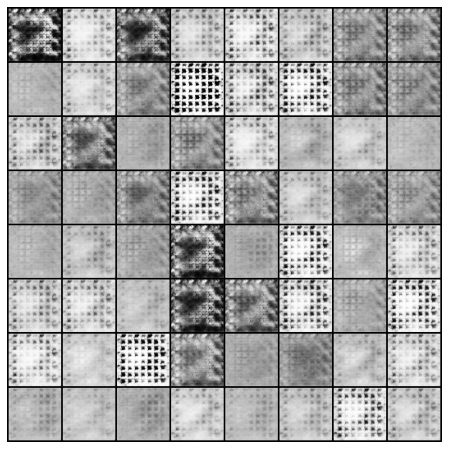

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.1455

[1/100][1/15]
- E_loss: 0.1671

[1/100][2/15]
- E_loss: 0.1361

[1/100][3/15]
- E_loss: 0.1067

[1/100][4/15]
- E_loss: 0.1139

[1/100][5/15]
- E_loss: 0.1038

[1/100][6/15]
- E_loss: 0.1289

[1/100][7/15]
- E_loss: 0.1174

[1/100][8/15]
- E_loss: 0.1321

[1/100][9/15]
- E_loss: 0.0994

[1/100][10/15]
- E_loss: 0.1288

[1/100][11/15]
- E_loss: 0.1101

[1/100][12/15]
- E_loss: 0.0996

[1/100][13/15]
- E_loss: 0.1500

[1/100][14/15]
- E_loss: 0.1476

[2/100][0/15]
- E_loss: 0.1060

[2/100][1/15]
- E_loss: 0.1380

[2/100][2/15]
- E_loss: 0.1236

[2/100][3/15]
- E_loss: 0.0742

[2/100][4/15]
- E_loss: 0.0868

[2/100][5/15]
- E_loss: 0.0813

[2/100][6/15]
- E_loss: 0.0772

[2/100][7/15]
- E_loss: 0.0918

[2/100][8/15]
- E_loss: 0.0908

[2/100][9/15]
- E_loss: 0.0852

[2/100][10/15]
- E_loss: 0.0954

[2/100][11/15]
- E_loss: 0.0874

[2/100][12/15]
- E_loss: 0.0800

[2/100][13/15]
- E_loss: 0.1004

[2/100][14/15]
- E_loss: 0.0774

[3/100][0/15]
- E_loss: 0.1018

[17/100][12/15]
- E_loss: 0.0610

[17/100][13/15]
- E_loss: 0.0668

[17/100][14/15]
- E_loss: 0.0777

[18/100][0/15]
- E_loss: 0.0563

[18/100][1/15]
- E_loss: 0.0723

[18/100][2/15]
- E_loss: 0.0459

[18/100][3/15]
- E_loss: 0.0888

[18/100][4/15]
- E_loss: 0.0905

[18/100][5/15]
- E_loss: 0.0918

[18/100][6/15]
- E_loss: 0.0724

[18/100][7/15]
- E_loss: 0.0618

[18/100][8/15]
- E_loss: 0.0793

[18/100][9/15]
- E_loss: 0.0596

[18/100][10/15]
- E_loss: 0.0629

[18/100][11/15]
- E_loss: 0.0645

[18/100][12/15]
- E_loss: 0.0509

[18/100][13/15]
- E_loss: 0.0656

[18/100][14/15]
- E_loss: 0.0814

[19/100][0/15]
- E_loss: 0.0719

[19/100][1/15]
- E_loss: 0.0706

[19/100][2/15]
- E_loss: 0.0839

[19/100][3/15]
- E_loss: 0.0611

[19/100][4/15]
- E_loss: 0.0688

[19/100][5/15]
- E_loss: 0.0637

[19/100][6/15]
- E_loss: 0.0778

[19/100][7/15]
- E_loss: 0.0665

[19/100][8/15]
- E_loss: 0.0587

[19/100][9/15]
- E_loss: 0.0617

[19/100][10/15]
- E_loss: 0.0577

[19/100][11/15]
- E_loss: 0.0550



[34/100][3/15]
- E_loss: 0.0762

[34/100][4/15]
- E_loss: 0.0879

[34/100][5/15]
- E_loss: 0.0567

[34/100][6/15]
- E_loss: 0.0741

[34/100][7/15]
- E_loss: 0.0699

[34/100][8/15]
- E_loss: 0.0661

[34/100][9/15]
- E_loss: 0.0572

[34/100][10/15]
- E_loss: 0.0505

[34/100][11/15]
- E_loss: 0.0645

[34/100][12/15]
- E_loss: 0.0560

[34/100][13/15]
- E_loss: 0.0755

[34/100][14/15]
- E_loss: 0.0557

[35/100][0/15]
- E_loss: 0.0752

[35/100][1/15]
- E_loss: 0.0585

[35/100][2/15]
- E_loss: 0.0747

[35/100][3/15]
- E_loss: 0.0610

[35/100][4/15]
- E_loss: 0.0754

[35/100][5/15]
- E_loss: 0.0558

[35/100][6/15]
- E_loss: 0.0718

[35/100][7/15]
- E_loss: 0.0712

[35/100][8/15]
- E_loss: 0.0660

[35/100][9/15]
- E_loss: 0.0625

[35/100][10/15]
- E_loss: 0.0558

[35/100][11/15]
- E_loss: 0.0609

[35/100][12/15]
- E_loss: 0.0687

[35/100][13/15]
- E_loss: 0.0666

[35/100][14/15]
- E_loss: 0.0713

[36/100][0/15]
- E_loss: 0.0898

[36/100][1/15]
- E_loss: 0.0525

[36/100][2/15]
- E_loss: 0.0643



[50/100][9/15]
- E_loss: 0.0622

[50/100][10/15]
- E_loss: 0.0560

[50/100][11/15]
- E_loss: 0.0700

[50/100][12/15]
- E_loss: 0.0602

[50/100][13/15]
- E_loss: 0.0749

[50/100][14/15]
- E_loss: 0.0682

[51/100][0/15]
- E_loss: 0.0554

[51/100][1/15]
- E_loss: 0.0816

[51/100][2/15]
- E_loss: 0.0660

[51/100][3/15]
- E_loss: 0.0596

[51/100][4/15]
- E_loss: 0.0983

[51/100][5/15]
- E_loss: 0.0711

[51/100][6/15]
- E_loss: 0.0606

[51/100][7/15]
- E_loss: 0.0610

[51/100][8/15]
- E_loss: 0.0561

[51/100][9/15]
- E_loss: 0.0592

[51/100][10/15]
- E_loss: 0.0742

[51/100][11/15]
- E_loss: 0.0689

[51/100][12/15]
- E_loss: 0.0554

[51/100][13/15]
- E_loss: 0.0537

[51/100][14/15]
- E_loss: 0.0511

[52/100][0/15]
- E_loss: 0.0843

[52/100][1/15]
- E_loss: 0.0538

[52/100][2/15]
- E_loss: 0.0725

[52/100][3/15]
- E_loss: 0.0615

[52/100][4/15]
- E_loss: 0.0651

[52/100][5/15]
- E_loss: 0.0606

[52/100][6/15]
- E_loss: 0.0640

[52/100][7/15]
- E_loss: 0.0597

[52/100][8/15]
- E_loss: 0.0613



[67/100][0/15]
- E_loss: 0.0675

[67/100][1/15]
- E_loss: 0.0582

[67/100][2/15]
- E_loss: 0.0834

[67/100][3/15]
- E_loss: 0.0708

[67/100][4/15]
- E_loss: 0.0532

[67/100][5/15]
- E_loss: 0.0599

[67/100][6/15]
- E_loss: 0.0768

[67/100][7/15]
- E_loss: 0.0514

[67/100][8/15]
- E_loss: 0.0539

[67/100][9/15]
- E_loss: 0.0609

[67/100][10/15]
- E_loss: 0.0858

[67/100][11/15]
- E_loss: 0.0598

[67/100][12/15]
- E_loss: 0.0760

[67/100][13/15]
- E_loss: 0.0621

[67/100][14/15]
- E_loss: 0.0459

[68/100][0/15]
- E_loss: 0.0599

[68/100][1/15]
- E_loss: 0.0712

[68/100][2/15]
- E_loss: 0.0666

[68/100][3/15]
- E_loss: 0.0434

[68/100][4/15]
- E_loss: 0.0622

[68/100][5/15]
- E_loss: 0.0650

[68/100][6/15]
- E_loss: 0.0621

[68/100][7/15]
- E_loss: 0.0644

[68/100][8/15]
- E_loss: 0.0643

[68/100][9/15]
- E_loss: 0.0747

[68/100][10/15]
- E_loss: 0.0797

[68/100][11/15]
- E_loss: 0.0689

[68/100][12/15]
- E_loss: 0.0608

[68/100][13/15]
- E_loss: 0.0586

[68/100][14/15]
- E_loss: 0.0654



[83/100][6/15]
- E_loss: 0.0639

[83/100][7/15]
- E_loss: 0.0777

[83/100][8/15]
- E_loss: 0.0521

[83/100][9/15]
- E_loss: 0.0492

[83/100][10/15]
- E_loss: 0.0533

[83/100][11/15]
- E_loss: 0.0515

[83/100][12/15]
- E_loss: 0.0641

[83/100][13/15]
- E_loss: 0.0616

[83/100][14/15]
- E_loss: 0.0744

[84/100][0/15]
- E_loss: 0.0782

[84/100][1/15]
- E_loss: 0.0503

[84/100][2/15]
- E_loss: 0.0812

[84/100][3/15]
- E_loss: 0.0548

[84/100][4/15]
- E_loss: 0.0666

[84/100][5/15]
- E_loss: 0.0658

[84/100][6/15]
- E_loss: 0.0564

[84/100][7/15]
- E_loss: 0.0694

[84/100][8/15]
- E_loss: 0.0654

[84/100][9/15]
- E_loss: 0.0531

[84/100][10/15]
- E_loss: 0.0564

[84/100][11/15]
- E_loss: 0.0729

[84/100][12/15]
- E_loss: 0.0647

[84/100][13/15]
- E_loss: 0.0564

[84/100][14/15]
- E_loss: 0.0657

[85/100][0/15]
- E_loss: 0.0696

[85/100][1/15]
- E_loss: 0.0675

[85/100][2/15]
- E_loss: 0.0707

[85/100][3/15]
- E_loss: 0.0602

[85/100][4/15]
- E_loss: 0.0551

[85/100][5/15]
- E_loss: 0.0532



[99/100][12/15]
- E_loss: 0.0630

[99/100][13/15]
- E_loss: 0.0568

[99/100][14/15]
- E_loss: 0.0491

[100/100][0/15]
- E_loss: 0.0374

[100/100][1/15]
- E_loss: 0.0637

[100/100][2/15]
- E_loss: 0.0661

[100/100][3/15]
- E_loss: 0.0653

[100/100][4/15]
- E_loss: 0.0719

[100/100][5/15]
- E_loss: 0.0627

[100/100][6/15]
- E_loss: 0.0610

[100/100][7/15]
- E_loss: 0.0533

[100/100][8/15]
- E_loss: 0.0662

[100/100][9/15]
- E_loss: 0.0747

[100/100][10/15]
- E_loss: 0.0776

[100/100][11/15]
- E_loss: 0.0481

[100/100][12/15]
- E_loss: 0.0809

[100/100][13/15]
- E_loss: 0.0553

[100/100][14/15]
- E_loss: 0.0667



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

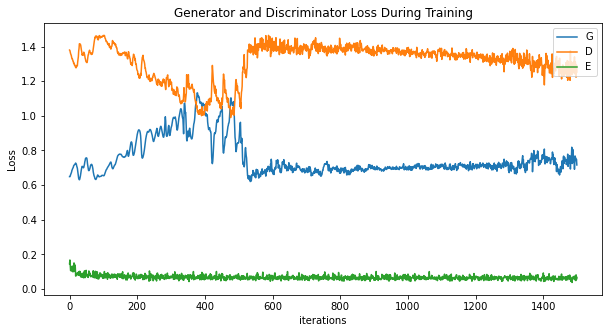

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

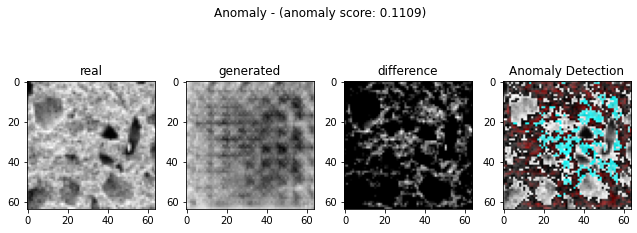

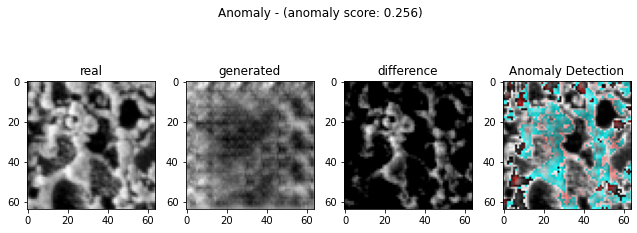

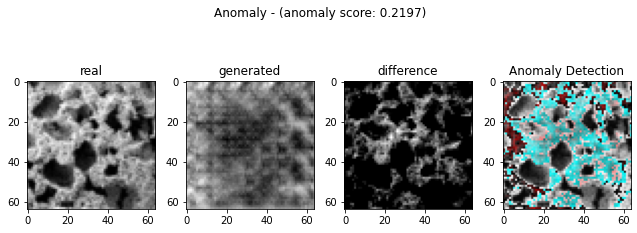

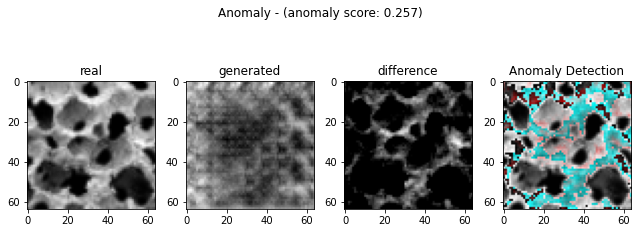

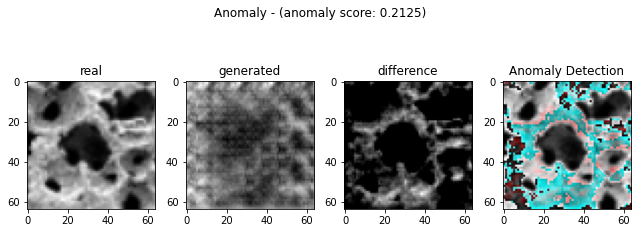

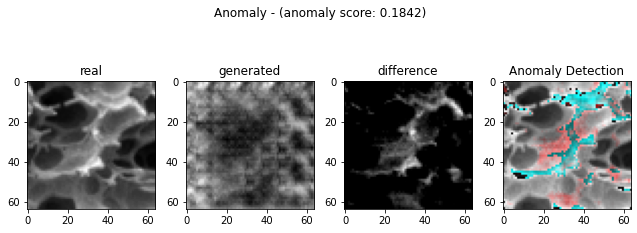

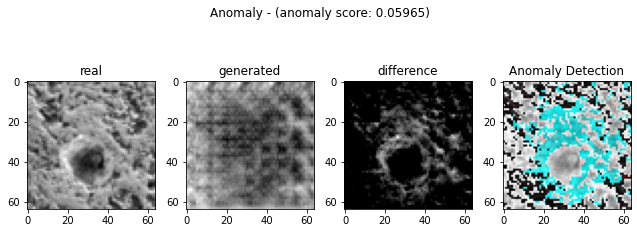

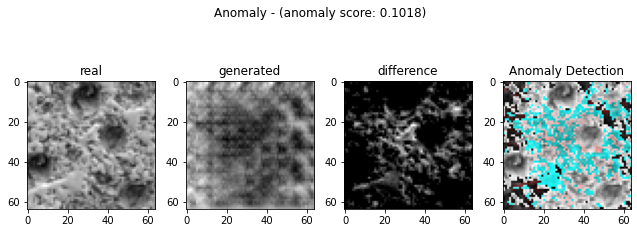

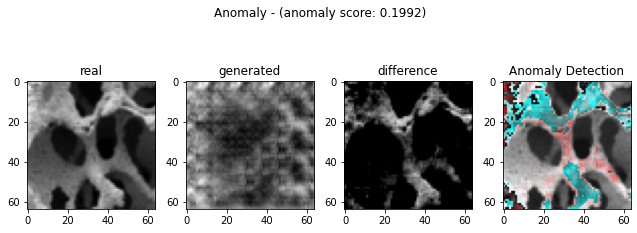

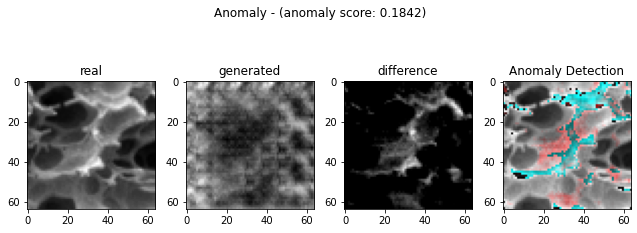

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.46630859 0.45922852 0.49243164 0.46850586 0.5065918  0.34765625
 0.4362793  0.46801758 0.36572266 0.34765625]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.43583984375

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.013172075654602492, 0.07388775652261584, 0.03904043198889945, -0.04362666451023564, -0.127848084878203, -0.26042300952572817, 0.005768070875368951, -0.11189205425822385, 0.15111594379278956, -0.26042300952572817]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

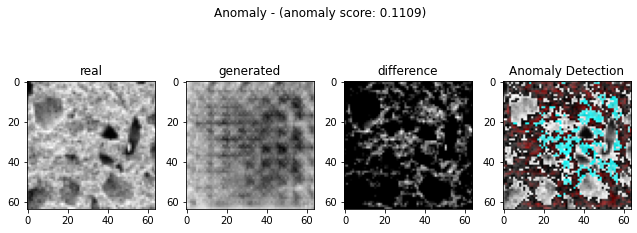

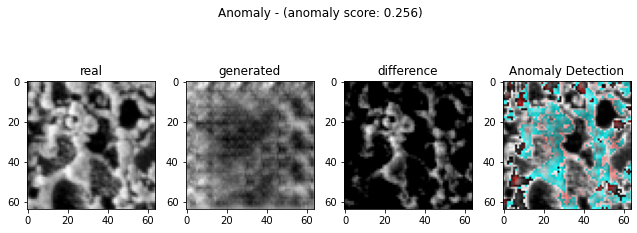

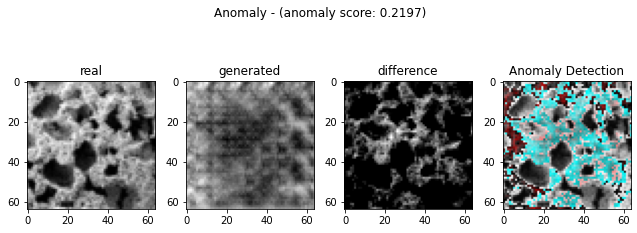

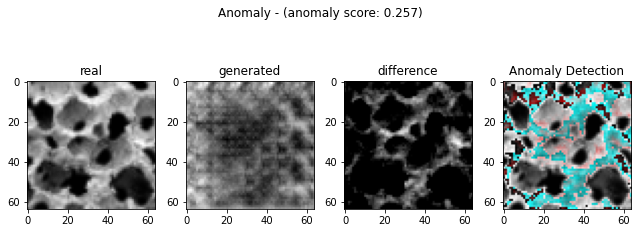

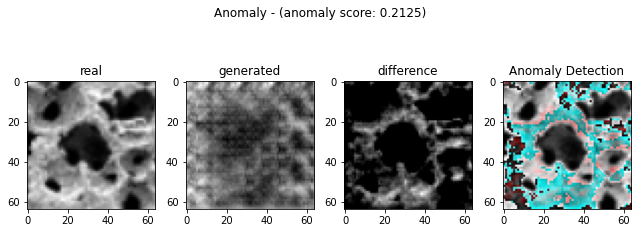

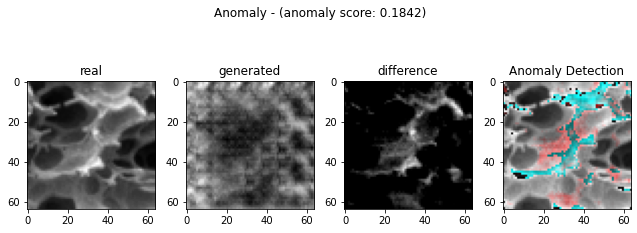

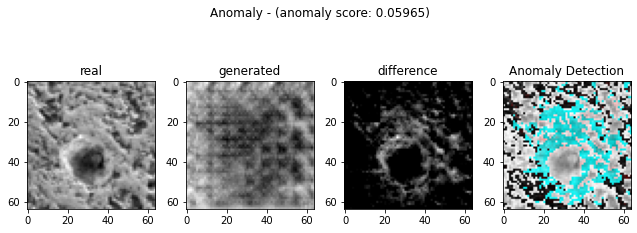

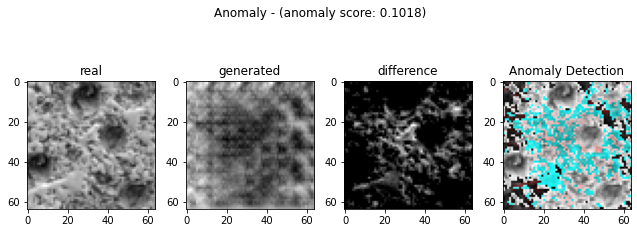

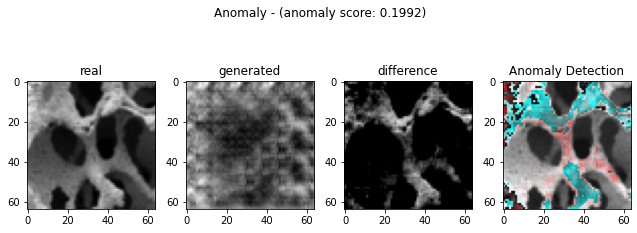

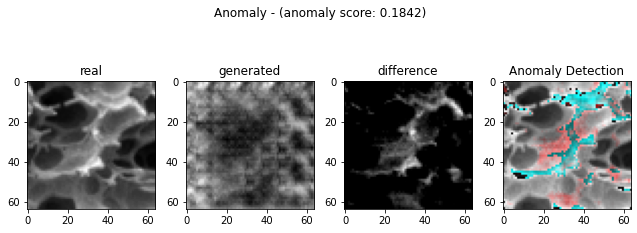

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.46630859 0.45922852 0.49243164 0.46850586 0.5065918  0.34765625
 0.4362793  0.46801758 0.36572266 0.34765625]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.013172075654602492, 0.07388775652261584, 0.03904043198889945, -0.04362666451023564, -0.127848084878203, -0.26042300952572817, 0.005768070875368951, -0.11189205425822385, 0.15111594379278956, -0.26042300952572817]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [186, 186, 186],
         [113, 104, 104],
         ...,
         [ 51,  51,  51],
         [117,  44,  44],
         [111,  58,  58]],
 
        [[  5,   5,   5],
         [ 35,  35,  35],
         [204, 204, 204],
         ...,
         [ 49,  21,  21],
         [ 61,  27,  27],
         [ 53,  53,  53]],
 
        [[  7,   7,   7],
         [  9,   9,   9],
         [ 57,  57,  57],
         ...,
         [192, 192, 192],
         [238, 238, 238],
         [ 75,  75,  75]],
 
        ...,
 
        [[113, 113, 113],
         [158, 158, 158],
         [184, 184, 184],
         ...,
         [ 55,  55,  55],
         [ 45,  45,  45],
         [ 53,  53,  53]],
 
        [[132, 132, 132],
         [176, 176, 176],
         [202, 202, 202],
         ...,
         [246, 246, 246],
         [ 17,  17,  17],
         [ 41,  41,  41]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [162, 162, 162],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[2.06574707 2.03438232 2.18147217 2.07548096 2.24420166 1.54011719
 1.93271729 2.07331787 1.62015137 1.54011719]
